In [40]:
import os
import re
import io
import ast
import sys
import json
import boto3 
import pymongo 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from urllib import request

sys.path.append("../")
import cabutils

In [41]:
projName = "mlve"
experimentName = "gestalt_shapegen_object-loc"
iterName = "72122_gestalt_shapegen"
S3_BUCKET_NAME = "gestalt-scenes"

# Downloading data from ec2 server (mostly just instructions for thomas)

In `settings.conf` change the `MONGODB_PORT` to 8000, and the `MONGODB_HOST` to `localhost`. Then run the ssh port into the ec2 server: 

```
ssh -i path/to/pem/key/maybe-named-something-like/Cocosci_WebExperiments.pem -fNL 8000:localhost:27017 ubuntu@ec2-54-91-252-25.compute-1.amazonaws.com
```

Change the path to the pem key, but otherwise this should all stay the same.

In [42]:
conn = cabutils.get_db_connection()
db = conn[projName + "_outputs"]
col = db[experimentName]

Checking database connection...
Connection established!


In [43]:
def results_to_df():
    results = []
    cursor = col.find({})
    for document in cursor:
        results.append(document)
    
    df = pd.DataFrame(results)
    return df

df = results_to_df()
df.head(10)

,_id,image_url,probe_touching,probe_location,gt_bounding_box,mask_idx,mask_val,meta,is_duplicate,attention_check,...,time_elapsed,internal_node_id,gameid,iterationName,inputid,projName,expName,sessionID,studyID,userID
0,62d9a356d72a4a05052b74af,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[340, 244]","[[289, 219], [462, 389]]",0.0,0.0,{},False,False,...,431978,0.0-9.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f
1,62d9a35dd72a4a05052b74c3,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[101, 346]",[],0.0,0.0,{},False,False,...,438691,0.0-10.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f
2,62d9a369d72a4a05052b74d8,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[466, 379]",[],0.0,0.0,{},False,False,...,450852,0.0-11.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f
3,62d9a37fd72a4a05052b7515,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[189, 221]","[[43, 102], [340, 339]]",0.0,0.0,{},False,False,...,473066,0.0-12.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f
4,62d9a383d72a4a05052b751b,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[86, 258]",[],0.0,0.0,{},False,False,...,477057,0.0-13.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f
5,62d9a393d72a4a05052b7547,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[442, 354]",[],0.0,0.0,{},False,False,...,493280,0.0-14.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f
6,62d9a3a5d72a4a05052b7574,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[324, 317]","[[211, 242], [380, 492]]",0.0,0.0,{},False,False,...,510640,0.0-15.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f
7,62d9a3b5d72a4a05052b759c,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[172, 392]",[],0.0,0.0,{},False,False,...,526557,0.0-16.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f
8,62d9a3c1d72a4a05052b75bb,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[229, 311]",[],0.0,0.0,{},False,False,...,539422,0.0-17.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f
9,62d9a3ddd72a4a05052b7601,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[281, 328]","[[190, 242], [353, 373]]",0.0,0.0,{},False,False,...,567514,0.0-18.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f


In [44]:
def download_from_s3(url, resource_type="image"):
    s3 = boto3.resource('s3', region_name="us-east-2")
    bucket = s3.Bucket(S3_BUCKET_NAME)
    item = bucket.Object(url)
    if resource_type == "image":
        file_stream = io.BytesIO()
        item.download_fileobj(file_stream)
        img = Image.open(file_stream)
        return img
    
    else:
        return item

In [45]:
def download_from_url(url):
    obj = request.urlretrieve(url)
    image = Image.open(obj[0])
    return image

In [46]:
def process_box(box):
    """
    Expects box as a tuple, of start stop points. Returns it as: [minX, minY, maxX, maxY]
    """
    minX = min(box[0][0], box[1][0])
    maxX = max(box[0][0], box[1][0])
    
    minY = min(box[0][1], box[1][1])
    maxY = max(box[0][1], box[1][1])
    
    return [int(minX), int(minY), int(maxX), int(maxY)]

def calc_mIOU(box_a, box_b, epsilon=1e-8):
    if not box_a and not box_b:
        return float("nan")
    if not box_a or not box_a:
        return 0
    
    if len(box_a) < 4:
        a = process_box(box_a)
    else:
        a = box_a
    
    if len(box_b) < 4:
        b = process_box(box_b)
    else:
        b = box_b
        
    # return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

    # COORDINATES OF THE INTERSECTION BOX
    
    xA = max(a[0], b[0])
    yA = max(a[1], b[1])
    xB = min(a[2], b[2])
    yB = min(a[3], b[3])
    
    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both AABBs
    bb1_area = (a[2] - a[0] + 1) * (a[3] - a[1] + 1)
    bb2_area = (b[2] - b[0] + 1) * (b[3] - b[1] + 1)
    if intersection_area == (bb1_area + bb2_area):
        return float('nan')
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou


In [47]:
# df.to_csv(EXPERIMENT_NAME + "-results.csv")

In [48]:
df["correct"].mean()

0.8917972911276822

# Generate cleaned version

In [49]:
df.head()

,_id,image_url,probe_touching,probe_location,gt_bounding_box,mask_idx,mask_val,meta,is_duplicate,attention_check,...,time_elapsed,internal_node_id,gameid,iterationName,inputid,projName,expName,sessionID,studyID,userID
0,62d9a356d72a4a05052b74af,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[340, 244]","[[289, 219], [462, 389]]",0.0,0.0,{},False,False,...,431978,0.0-9.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f
1,62d9a35dd72a4a05052b74c3,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[101, 346]",[],0.0,0.0,{},False,False,...,438691,0.0-10.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f
2,62d9a369d72a4a05052b74d8,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[466, 379]",[],0.0,0.0,{},False,False,...,450852,0.0-11.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f
3,62d9a37fd72a4a05052b7515,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[189, 221]","[[43, 102], [340, 339]]",0.0,0.0,{},False,False,...,473066,0.0-12.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f
4,62d9a383d72a4a05052b751b,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[86, 258]",[],0.0,0.0,{},False,False,...,477057,0.0-13.0,5596-70eb1b25-a9e0-48e2-afb3-75ea35acecb0,72122_gestalt_shapegen,None,mlve,gestalt_shapegen_object-loc,62d9a18ce2e8f001376986ae,62d9a1239f22765e27c5d31d,5f3d0d26b54d1abf0f2fd31f


## Let's quickly look at the comments

In [50]:
all_comments = df[df["trial_type"] == "survey-text"]["response"]
comments = []
for response in all_comments:
    comm = response["Q0"]
    if len(comm) > 0:
        comments.append(comm)
print(comments)

['Thank you for the Japanese Macaque!', 'Very good', 'some of the patterns did confuse my eyes slightly and may cause a headache to form , just a note , because i get that the patterns are meant to be confusing', 'Thanks', 'Finish', "A few of the patterns were much harder to determine than others - also, it would have been nice to have an option to go back, incase of a misclick of 'yes', and then having to draw a random rectangle", 'No, thanks', 'Finish', 'No', 'All the objects look like Angels from Neon Genesis Evangellion', 'The macques were hilarious and welcome, thank you!', "I can't think of any!", 'Ow my brain', 'Really enjoyed this', 'Enjoyable study!', 'no', 'That was fun. It would of been better to draw an outline around the shapes with curves and all rather than just a box. ', '5ee944d1886b7d1b8481387d', 'Very interesting to see how the different backgrounds interacted with the shapes - thanks!', 'no', 'no', 'that was really hard and i have no idea how i done lol but thanks f

In [51]:
df.drop(df[df["trial_type"] != "object-localization-task"].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6571 entries, 0 to 6650
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _id                   6571 non-null   object 
 1   image_url             6571 non-null   object 
 2   probe_touching        6571 non-null   object 
 3   probe_location        6571 non-null   object 
 4   gt_bounding_box       6571 non-null   object 
 5   mask_idx              6571 non-null   float64
 6   mask_val              6571 non-null   float64
 7   meta                  6571 non-null   object 
 8   is_duplicate          6571 non-null   object 
 9   attention_check       6571 non-null   object 
 10  batch_num             6571 non-null   float64
 11  rt                    6571 non-null   int64  
 12  stimulus              6571 non-null   object 
 13  response              6571 non-null   object 
 14  correct               6571 non-null   object 
 15  subject_bounding_box 

In [60]:
participants = df.groupby("userID")
participants_failed = []
i = 0 
n_trials = 81
score_threshold = 0.5


for index, user_results in participants:
    i += 1
    trials_finished = len(user_results)
    if trials_finished < n_trials - 10:
        print("USER ID: " + user_results["userID"].iloc[0] + " only completed: " + str(trials_finished) + " trials")
        participants_failed.append(user_results["userID"].iloc[0])
        continue
    
    correct_score = user_results["correct"].mean()
    if correct_score < score_threshold:
        print("USER ID: " + user_results["userID"].iloc[0] + " scored " + str(correct_score))
        participants_failed.append(user_results["userID"].iloc[0])
        continue
        
#     attention_checks = user_results[user_results["stimulus"].str.contains("ground_truth")]
#     if attention_checks["correct"].sum() < 2:
#         print("USER ID: " + user_results["userID"].iloc[0] + " faled too many attention checks")
#         participants_failed.append(user_results["userID"].iloc[0])

# participants_failed.append("60cb62a4e099dcbffe591021")
# participants_failed.append("5ec3d06016290204b072564d")
print(participants_failed)

USER ID: 5eb29fdddac67500082c1089 scored 0.4691358024691358
USER ID: 60ae4319bf058958a5dedcc6 scored 0.48148148148148145
USER ID: 60fb323fd098c157e1e985ae scored 0.4691358024691358
USER ID: 62ac80c7bb52b8c5e8ba266d scored 0.4567901234567901
USER ID: 62d989d7c133a0fdc2301666 only completed: 12 trials
['5eb29fdddac67500082c1089', '60ae4319bf058958a5dedcc6', '60fb323fd098c157e1e985ae', '62ac80c7bb52b8c5e8ba266d', '62d989d7c133a0fdc2301666']


In [62]:
remove_failure_cases = False

In [63]:
if remove_failure_cases:
    failed_participants = df["userID"].apply(lambda x: x in participants_failed)
    df = df[~failed_participants]
    attention_checks = df["stimulus"].apply(lambda x: "ground_truth" in x)
    df = df[~attention_checks]

In [ ]:
len(df[df["texture_name"] == ""])

# Create directory for figures

In [ ]:
if not os.path.exists(f"figures/{experimentName}"):
    os.makedirs(f"figures/{experimentName}")

## Create texture_name column

In [ ]:
df["texture_name"] = df["stimulus"].apply(lambda x: x.split(".com/")[1].split("/")[0].split("_")[1])
df["texture_name"] = df["texture_name"].apply(lambda x: "Dots" if x == "voronoi" else x.capitalize())

In [64]:
ious = []
for index, row in df.iterrows():
    gtbb = row["gt_bounding_box"]
    if type(gtbb) == str:
        gtbb = str_to_list(gtbb)
    ubb = row["subject_bounding_box"]
    if type(ubb) == str:
        ubb = str_to_list(ubb)

    if (not ubb and not gtbb) or (ubb and not gtbb):
        ious.append(float("nan"))
        continue 

    elif (not ubb and gtbb):
        ious.append(0)
        continue

    else:
        iou = calc_mIOU(gtbb, ubb)
        ious.append(iou)

df["miou"] = ious

In [71]:
user_means = df.groupby("userID")["miou"].mean()
low_miou = user_means[user_means < 0.2]
low_miou_user_ids = [x for x in low_miou.keys()]
all_participants_failed = low_miou_user_ids

In [72]:
participants_failed

['5eb29fdddac67500082c1089',
 '60ae4319bf058958a5dedcc6',
 '60fb323fd098c157e1e985ae',
 '62ac80c7bb52b8c5e8ba266d',
 '62d989d7c133a0fdc2301666']

In [73]:
low_miou_user_ids

['62ac80c7bb52b8c5e8ba266d']

In [68]:
all_participants_failed

['5eb29fdddac67500082c1089',
 '60ae4319bf058958a5dedcc6',
 '60fb323fd098c157e1e985ae',
 '62ac80c7bb52b8c5e8ba266d',
 '62d989d7c133a0fdc2301666',
 '5eb29fdddac67500082c1089',
 '60fb323fd098c157e1e985ae',
 '62ac80c7bb52b8c5e8ba266d']

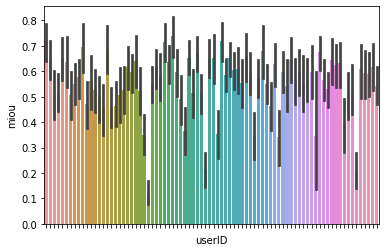

In [74]:
g = sns.barplot(y="miou", x="userID", data=df)
g.set(xticklabels=[])
plt.show()

In [75]:
df["miou"].mean()

0.5553013631151564

Text(0.5, 1.0, 'Participant accuracy')

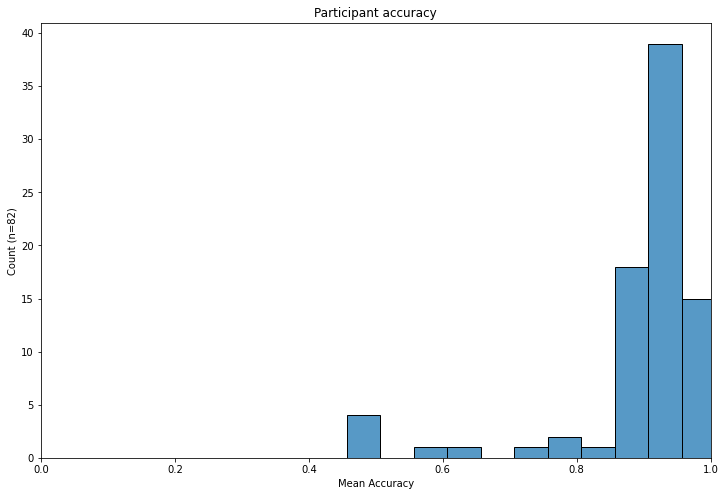

In [78]:
accuracies = []
textures = []
target = "userID"
challenging_stimuli = []
for index, trials in df.groupby(target): 
    accuracy = trials["correct"].mean()
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("Mean Accuracy")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"Participant accuracy")
# plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")

Text(0.5, 1.0, 'Trial level accuracy')

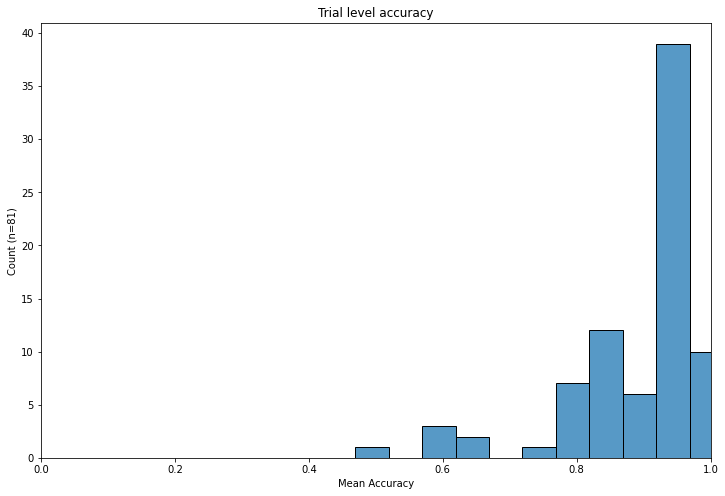

In [79]:
accuracies = []
textures = []
target = "stimulus"
challenging_stimuli = []
for index, trials in df.groupby(target): 
    accuracy = trials["correct"].mean()
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("Mean Accuracy")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"Trial level accuracy")
# plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")

In [ ]:
data = []
challenging_stimuli = []
for index, trials in df.groupby(["userID", "n_objs"]): 
    
    accuracy = trials["correct"].mean()
    user_id = trials["userID"].iloc[0]
    texture_name = trials["n_objs"].iloc[0]
    
    data.append({"accuracy": accuracy, "userID": user_id, "texture": texture_name})
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    

tempdf = pd.DataFrame(data)

figure, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(y="accuracy", x="texture", data=tempdf)
ax = sns.swarmplot(y="accuracy", x="texture", color="black", alpha=0.5, data=tempdf)

plt.ylabel("Mean Accuracy")
plt.xlabel(f"Number of Objects in scene")
plt.title(f"Accuracy by # objects across all users (n={len(df['userID'].unique())})")
# plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")



In [ ]:
data = []
challenging_stimuli = []
for index, trials in df.groupby(["stimulus", "n_objs"]): 
    
    accuracy = trials["correct"].mean()
    stimulus_id = trials["stimulus"].iloc[0]
    n_objs = trials["n_objs"].iloc[0]
    
    data.append({"accuracy": accuracy, "stimulus": stimulus_id, "n_objs": n_objs})
    
    accuracies.append(accuracy)
    

tempdf = pd.DataFrame(data)

figure, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(y="accuracy", x="n_objs", data=tempdf)
ax = sns.stripplot(y="accuracy", x="n_objs", color="black", alpha=0.5, data=tempdf)

plt.ylabel("Mean Accuracy")
plt.xlabel(f"Number of Objects in scene")
plt.title(f"Accuracy by # objects across stimulus (n={len(df['stimulus'].unique())})")
# plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")



# Accuracy across all textures

In [ ]:
accuracies = []
textures = []
target = "stimulus"

for index, trials in df.groupby(target): 
    accuracy = trials["correct"].mean()
    accuracies.append(accuracy)
    if trials["texture_name"].iloc[0] == "":
        continue
    textures.append(trials["texture_name"].iloc[0])
    
    
tempdf = pd.DataFrame({"textures": textures, "accuracies": accuracies})

figure = plt.figure(figsize=(12,8))
sns.boxplot(y="accuracies", x="textures", data=tempdf, order=["Dots", "Noise", "Wave"])

plt.xlabel("Texture type (40 stimuli per texture)")
plt.ylabel(f"Accuracy per stimuli")
plt.title(f"Accuracy by texture type across stimulus")
# plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")


In [ ]:
accuracies = []
textures = []
target = "userID"
challenging_stimuli = []
for index, trials in df.groupby([target, "texture_name"]): 
    accuracy = trials["correct"].mean()

    
    accuracies.append(accuracy)
    textures.append(trials["texture_name"].iloc[0])
    
    
tempdf = pd.DataFrame({"textures": textures, "accuracies": accuracies})

figure = plt.figure(figsize=(12,8))
sns.boxplot(y="accuracies", x="textures", data=tempdf, order=["Dots", "Noise", "Wave"])

plt.xlabel("Texture type (40 stimuli per texture)")
plt.ylabel(f"Accuracy per stimuli")
plt.title(f"Accuracy by texture type across users")
# plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")


#  mIOU


Text(0.5, 1.0, 'mIOU per-participant')

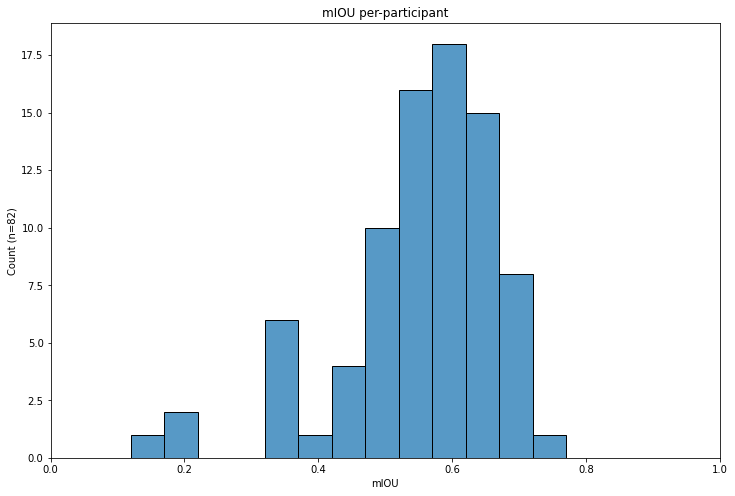

In [82]:
accuracies = []
textures = []
target = "userID"
challenging_stimuli = []
for index, trials in df.groupby(target): 
    accuracy = trials["miou"].mean()
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("mIOU")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"mIOU per-participant")
# plt.savefig(f"figures/{experimentName}/mean_miou_hist_per_{target}.png")

Text(0.5, 1.0, 'mIOU per-stimuli')

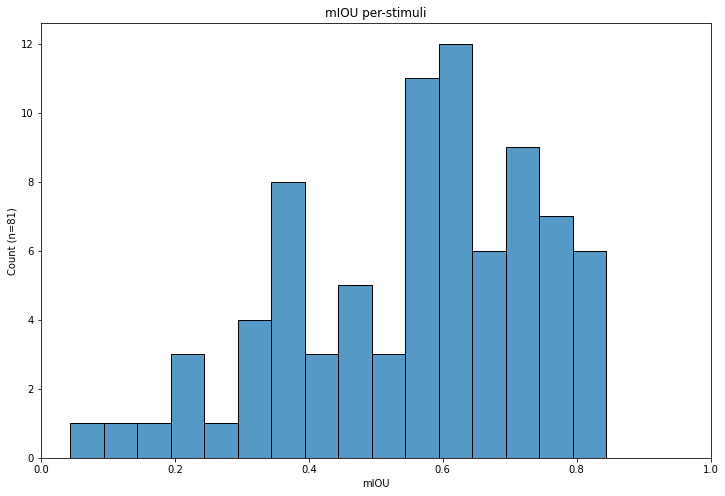

In [83]:
accuracies = []
textures = []
target = "stimulus"
challenging_stimuli = []
for index, trials in df.groupby(target): 
    accuracy = trials["miou"].mean()
    
    if accuracy < 0.25:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("mIOU")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"mIOU per-stimuli")
# plt.savefig(f"figures/{experimentName}/mean_miou_hist_per_{target}.png")

In [84]:
challenging_stimuli

[(0.20594961183412444,
  'https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_007.png'),
 (0.112761056193529,
  'https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_026.png'),
 (0.23320476150561667,
  'https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_029.png'),
 (0.14603343587941262,
  'https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_037.png'),
 (0.04404901355509162,
  'https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_064.png'),
 (0.20220472544378015,
  'https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_078.png')]

In [ ]:
data = []
challenging_stimuli = []
for index, trials in df.groupby(["userID", "n_objs"]): 
    
    accuracy = trials["miou"].mean()
    user_id = trials["userID"].iloc[0]
    texture_name = trials["n_objs"].iloc[0]
    
    data.append({"accuracy": accuracy, "user_id": user_id, "texture": texture_name})
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    

tempdf = pd.DataFrame(data)

figure, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(y="accuracy", x="texture", data=tempdf)
ax = sns.swarmplot(y="accuracy", x="texture", color="black", alpha=0.5, data=tempdf)

plt.ylabel("mIOU")
plt.xlabel(f"Number of Objects in scene")
plt.title(f"mIOU by # objects across all users (n={len(df['userID'].unique())})")
plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")



In [ ]:
data = []
challenging_stimuli = []
for index, trials in df.groupby(["stimulus", "n_objs"]): 
    
    accuracy = trials["miou"].mean()
    user_id = trials["userID"].iloc[0]
    texture_name = trials["n_objs"].iloc[0]
    
    data.append({"accuracy": accuracy, "user_id": user_id, "texture": texture_name})
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    

tempdf = pd.DataFrame(data)

figure, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(y="accuracy", x="texture", data=tempdf)
ax = sns.swarmplot(y="accuracy", x="texture", color="black", alpha=0.5, data=tempdf)

plt.ylabel("mIOU")
plt.xlabel(f"Number of Objects in scene")
n_stimulus = len(df["stimulus"].unique())
plt.title(f"mIOU by # objects across all stimulus (n={n_stimulus})")
plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")



In [ ]:
data = []
challenging_stimuli = []
for index, trials in df.groupby(["userID", "texture_name"]): 
    
    accuracy = trials["miou"].mean()
    user_id = trials["userID"].iloc[0]
    texture_name = trials["texture_name"].iloc[0]
    
    data.append({"accuracy": accuracy, "user_id": user_id, "texture": texture_name})
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    

tempdf = pd.DataFrame(data)

figure, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(y="accuracy", x="texture", data=tempdf)
ax = sns.swarmplot(y="accuracy", x="texture", color="black", alpha=0.5, data=tempdf, order=["Dots", "Noise", "Wave"])

plt.ylabel("mIOU")
plt.xlabel(f"Number of Objects in scene")
plt.title(f"mIOU by texture type across all users (n={len(df['userID'].unique())})")
plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")



In [ ]:
data = []
challenging_stimuli = []
for index, trials in df.groupby(["stimulus", "texture_name"]): 
    
    accuracy = trials["miou"].mean()
    user_id = trials["userID"].iloc[0]
    texture_name = trials["texture_name"].iloc[0]
    
    data.append({"accuracy": accuracy, "user_id": user_id, "texture": texture_name})
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    

tempdf = pd.DataFrame(data)

figure, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(y="accuracy", x="texture", data=tempdf, order=["Dots", "Noise", "Wave"])
ax = sns.swarmplot(y="accuracy", x="texture", color="black", alpha=0.5, data=tempdf, order=["Dots", "Noise", "Wave"])

plt.ylabel("mIOU")
plt.xlabel(f"Number of Objects in scene")
plt.title(f"mIOU by texture type across all stimulus (n={n_stimulus})")
plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")




In [ ]:
def add_box(box, ax, alpha=0.8, color="red", linewidth=5):
    if len(box) != 4:
        box = process_box(box)
    width = box[2] - box[0]
    height = box[3] - box[1]
    if not color or color == "random":
        import random
        color = "#%06x" % random.randint(0, 0xFFFFFF)
        
    rect = patches.Rectangle((box[0], box[1]), width, height, linewidth=linewidth, edgecolor=color, 
                             alpha=alpha, facecolor='none')
    ax.add_patch(rect)
    return ax

def plot_trial(trial):
    fig, ax = plt.subplots(figsize=(16,12))
    print(trial["userID"])
    
    gt_bb = trial["gt_bounding_box"]
    s_bb = trial["subject_bounding_box"]
    
    print(gt_bb, s_bb)
    if gt_bb:
        add_box(gt_bb, ax, color="blue", alpha=0.75)
        
    if s_bb:
        add_box(s_bb, ax, color="red", alpha=0.75)
        
    url = trial["stimulus"]
    image = download_from_url(url)

    probe_location = trial["probe_location"]
    
    ax.imshow(image, cmap="gray")

    # Add probes
    probe = patches.Circle(probe_location, radius=12, color="#69597f", alpha=0.8)
    ax.add_patch(probe)
    probe = patches.Circle(probe_location, radius=4, color="#ff0601", alpha=1)
    ax.add_patch(probe)

    return fig

In [ ]:
for index, trial in df.iterrows():
    miou = calc_mIOU(trial["gt_bounding_box"], trial["subject_bounding_box"])
    print(miou)
    fig=plot_trial(trial)
    plt.show()
    plt.close()

In [ ]:
avg_bboxes = False
run_plots = True

save_path = "/Users/yoni/Desktop/static_detection_v1_user_bboxes/"
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
if run_plots:
    for index, trials in df.groupby("stimulus"):

        url = index
        image = download_from_url(url)

        # Add probes
        probe_location = trials.iloc[0]["probe_location"]
        probe_touching = trials.iloc[0]["probe_touching"]

        if not probe_touching:
            continue 

        fig, ax = plt.subplots(1,1, figsize=(16, 12))
        image = download_from_url(url)

        ax.imshow(image, cmap="gray")

        probe = patches.Circle(probe_location, radius=12, color="#69597f", alpha=0.8)
        ax.add_patch(probe)

        probe = patches.Circle(probe_location, radius=4, color="#ff0601", alpha=1)
        ax.add_patch(probe)

        gt_bb = trials.iloc[0]["gt_bounding_box"]
        ax = add_box(gt_bb, ax, color="red", linewidth=10, alpha=1)

        avg_bb = []
        count = 0
        for i, trial in trials.iterrows():
            s_bb = trial["subject_bounding_box"]
            if s_bb:
                if avg_bboxes:
                    box = np.array(process_box(s_bb))
                    count += 1
                    if not len(avg_bb):
                        avg_bb.append(box)
                    else:
                        avg_bb.append(box)
                else: 
                    add_box(s_bb, ax, alpha=0.5, linewidth=5, color="random")

        if avg_bboxes:
            avg_bb = np.array(avg_bb).mean(axis=0)
            add_box(avg_bb, ax, alpha=0.9, linewidth=5, color="blue")
            miou = calc_mIOU(avg_bb, gt_bb)
            print(miou)
        

        trial_name = url.split(".com")[1][1:].replace("/", "-")
        trial_name = trial_name.replace("-images", "")

        plt.title(trial_name)
        plt.savefig(os.path.join(save_path, trial_name + ".png"))
        plt.show()
        plt.close()

# Regress parameters that make this difficult

In [ ]:
import statsmodels.formula.api as sm_api
import statsmodels.api as sm


In [ ]:
attention_filtered.info()

In [ ]:
camera_loc = np.array([18.5, -18.2, 12.2])

## Extract texture params

In [ ]:
# Object parameters
get_distortion = lambda x: x["params"].get("Distortion", x["params"].get("Scale"))

attention_filtered["obj_scale"] = attention_filtered["obj_texture_data"].apply(lambda x: x["params"]["Scale"])
attention_filtered["obj_distortion"] = attention_filtered["obj_texture_data"].apply(get_distortion)

# Background parameters
attention_filtered["background_scale"] = attention_filtered["background_texture"].apply(
    lambda x: x["params"]["Scale"])
attention_filtered["background_distortion"] = attention_filtered["background_texture"].apply(get_distortion)

camera_dist = lambda x: np.sqrt(np.sum((np.array(x) - camera_loc) ** 2))
attention_filtered["obj_distance"] = attention_filtered["obj_location_data"].apply(camera_dist)

## Combine them

In [ ]:
attention_filtered["scale_diff"] = attention_filtered["obj_scale"] - attention_filtered["background_scale"]
attention_filtered["distortion_diff"] = attention_filtered["obj_distortion"] - \
                                        attention_filtered["background_distortion"]
attention_filtered["texture_categorical"] = attention_filtered["texture_name"].astype("category")

## Normalize everything

In [ ]:
attention_filtered["scale_diff"] = (attention_filtered["scale_diff"] - attention_filtered["scale_diff"].mean()) / \
                                    attention_filtered["scale_diff"].std()
    
attention_filtered["distortion_diff"] = (attention_filtered["distortion_diff"] - attention_filtered["distortion_diff"].mean()) / \
                                    attention_filtered["distortion_diff"].std()
    
attention_filtered["miou_norm"] = (attention_filtered["miou"] - attention_filtered["miou"].mean()) / \
                                    attention_filtered["miou"].std()
    
attention_filtered["obj_distance"] = (attention_filtered["obj_distance"] - attention_filtered["obj_distance"].mean()) / \
                                    attention_filtered["obj_distance"].std()
    

In [ ]:
fig, ax = plt.subplots()
exog_vars = ["obj_distance", "scale_diff", "distortion_diff"]
exog = attention_filtered[exog_vars]
sns.heatmap(exog.corr(), cmap="viridis")
plt.show()

keep_idxs = attention_filtered["miou"].notna()
X = sm.add_constant(exog[keep_idxs])
endog = attention_filtered["miou_norm"][keep_idxs]
model = sm.OLS(exog=X, endog=endog)
result = model.fit()

In [ ]:
print(result.summary())

In [ ]:
# fig = plt.figure(figsize=(10, 8))
fig = sm.graphics.plot_partregress_grid(result)
fig.tight_layout(pad=2)
